In [1]:
!set -e 

!mkdir -p datasets
!cd datasets
!wget http://www.iro.umontreal.ca/~lisa/datasets/profiledata_06-May-2005.tar.gz
!tar xvf profiledata_06-May-2005.tar.gz
!mv profiledata_06-May-2005/* datasets/
!rm -r profiledata_06-May-2005

--2022-03-03 22:07:51--  http://www.iro.umontreal.ca/~lisa/datasets/profiledata_06-May-2005.tar.gz
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135880312 (130M) [application/x-gzip]
Saving to: ‘profiledata_06-May-2005.tar.gz’

profiledata_06-May- 100%[===================>] 129.58M  16.3MB/s    in 9.2s    

2022-03-03 22:08:01 (14.1 MB/s) - ‘profiledata_06-May-2005.tar.gz’ saved [135880312/135880312]

profiledata_06-May-2005/
profiledata_06-May-2005/artist_data.txt
profiledata_06-May-2005/README.txt
profiledata_06-May-2005/user_artist_data.txt
profiledata_06-May-2005/artist_alias.txt


In [ ]:
!cat datasets/user_artist_data.txt |head

1000002 1 55
1000002 1000006 33
1000002 1000007 8
1000002 1000009 144
1000002 1000010 314
1000002 1000013 8
1000002 1000014 42
1000002 1000017 69
1000002 1000024 329
1000002 1000025 1


In [ ]:
!cat datasets/artist_data.txt |head

1134999	06Crazy Life
6821360	Pang Nakarin
10113088	Terfel, Bartoli- Mozart: Don
10151459	The Flaming Sidebur
6826647	Bodenstandig 3000
10186265	Jota Quest e Ivete Sangalo
6828986	Toto_XX (1977
10236364	U.S Bombs -
1135000	artist formaly know as Mat
10299728	Kassierer - Musik für beide Ohren


In [ ]:
!cat datasets/artist_alias.txt |head

1092764	1000311
1095122	1000557
6708070	1007267
10088054	1042317
1195917	1042317
1112006	1000557
1187350	1294511
1116694	1327092
6793225	1042317
1079959	1000557


In [2]:
import os, sys
import re
import random

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

In [3]:
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

#!pip install findspark
#import findspark 
#!pip install pyspark==2.4.4 
#import pyspark 

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)
     |████████████████████████████████| 215.7 MB 62 kB/s 
     |████████████████████████████████| 197 kB 22.4 MB/s 


In [4]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, LongType, IntegerType, StringType
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

In [5]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))


In [6]:
from pyspark.sql import Row
from pyspark.sql.functions import *

In [ ]:
sqlContext = SQLContext(sc)

In [7]:
directory_path = "datasets/"

In [ ]:
userArtistDataSchema = StructType([
    StructField("userID", LongType(), True),
    StructField("artistID", LongType(), True),
    StructField("playcount", IntegerType(), True)
])

userArtistDF = sqlContext.read.format('com.databricks.spark.csv').options(header='false', delimiter=' ').load(directory_path + 'user_artist_data.txt', schema=userArtistDataSchema).cache()

In [ ]:
userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playcount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



In [ ]:
userArtistDF.count() 

In [ ]:
totalUsers = userArtistDF.count()
print(" total number of users : {}".format(totalUsers))
distinctUsers = userArtistDF.select('userID').distinct().count()
print(" total number of distinct users : {}".format(distinctUsers))

 total number of users : 24296858
 total number of distinct users : 148111


In [ ]:
distinctArtists = userArtistDF.select('artistID').distinct().count()
print(" total number of distinct artists : {}".format(distinctArtists))

 total number of distinct artists : 1631028


In [ ]:
MAX_ID =  2147483647
negativeUserID = userArtistDF[(userArtistDF.userID.cast('int') < 0)]
print(" negative ID : {}".format(negativeUserID.show()))
invalidUserID = userArtistDF[(userArtistDF.userID.cast('int') > MAX_ID)]
print(" invalid ID : {}".format(invalidUserID.show()))

+------+--------+---------+
|userID|artistID|playcount|
+------+--------+---------+
+------+--------+---------+

 negative ID : None
+------+--------+---------+
|userID|artistID|playcount|
+------+--------+---------+
+------+--------+---------+

 invalid ID : None


In [ ]:
userArtistDF.select('userID').describe().show()

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|          24296858|
|   mean|1947573.2653533637|
| stddev| 496000.5551820078|
|    min|                90|
|    max|           2443548|
+-------+------------------+



In [ ]:
negativeArtistID = userArtistDF[(userArtistDF.userID.cast('int') < 0)]
print(" negative ID : {}".format(negativeArtistID.show()))
invalidArtistID = userArtistDF[(userArtistDF.userID.cast('int') > MAX_ID)]
print(" invalid ID : {}".format(invalidArtistID.show()))

In [ ]:
userArtistDF.select('artistID').describe().show()

+-------+------------------+
|summary|          artistID|
+-------+------------------+
|  count|          24296858|
|   mean|1718704.0937568964|
| stddev|2539389.0924284607|
|    min|                 1|
|    max|          10794401|
+-------+------------------+



In [ ]:
maxUserID = userArtistDF.agg({'userID' : 'max'}).show() 
maxUserID = userArtistDF.agg({'userID' : 'min'}).show() 
maxUserID = userArtistDF.agg({'artistID' : 'max'}).show() 
maxUserID = userArtistDF.agg({'artistID' : 'min'}).show() 

+-----------+
|max(userID)|
+-----------+
|    2443548|
+-----------+

+-----------+
|min(userID)|
+-----------+
|         90|
+-----------+

+-------------+
|max(artistID)|
+-------------+
|     10794401|
+-------------+

+-------------+
|min(artistID)|
+-------------+
|            1|
+-------------+



# Some Statistics

In [ ]:
userActivity = userArtistDF.groupBy('userID').sum('playCount').collect()
userActivity[:20]

[Row(userID=1000061, sum(playCount)=244),
 Row(userID=1000070, sum(playCount)=20200),
 Row(userID=1000313, sum(playCount)=201),
 Row(userID=1000832, sum(playCount)=1064),
 Row(userID=1000905, sum(playCount)=214),
 Row(userID=1001372, sum(playCount)=1336),
 Row(userID=1001409, sum(playCount)=18740),
 Row(userID=1001530, sum(playCount)=3013),
 Row(userID=1001700, sum(playCount)=635),
 Row(userID=1001731, sum(playCount)=4529),
 Row(userID=1001753, sum(playCount)=7761),
 Row(userID=1001872, sum(playCount)=9208),
 Row(userID=1002159, sum(playCount)=1313),
 Row(userID=1002420, sum(playCount)=10233),
 Row(userID=1002519, sum(playCount)=510),
 Row(userID=1002734, sum(playCount)=82),
 Row(userID=1003034, sum(playCount)=1012),
 Row(userID=1003076, sum(playCount)=1484),
 Row(userID=1003301, sum(playCount)=689),
 Row(userID=1004223, sum(playCount)=383)]

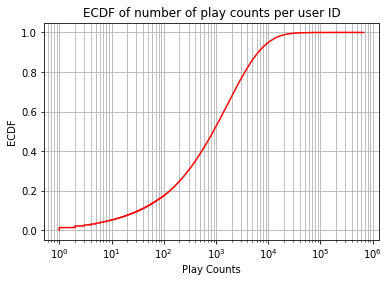

Sum = 371638969
Mean = 2509.1922206993404
Max = 674412
Min = 1
Percentile 25% = 204.0
Percentile 50% = 892.0
Percentile 75% = 2800.0
Percentile 90% = 6484.0
Percentile 95% = 10120.0
Percentile 97% = 13297.399999999965
The percentage of users who listen less than 10 times P(YUsr<=10) = 5.229%


In [ ]:
pdfUsr = pd.DataFrame(data=userActivity)
YUsr = np.sort(pdfUsr[1])
YUsrVals = np.arange(len(YUsr)) / float(len(YUsr))

plt.semilogx(YUsr, YUsrVals, color='red')
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls="-")
plt.title('ECDF of number of play counts per user ID')
plt.show()

print('Sum = {}'.format(YUsr.sum()))
print('Mean = {}'.format(YUsr.mean()))
print('Max = {}'.format(YUsr.max()))
print('Min = {}'.format(YUsr.min()))

print('Percentile 25% = {}'.format(np.percentile(YUsr, 25)))
print('Percentile 50% = {}'.format(np.percentile(YUsr, 50)))
print('Percentile 75% = {}'.format(np.percentile(YUsr, 75)))
print('Percentile 90% = {}'.format(np.percentile(YUsr, 90)))
print('Percentile 95% = {}'.format(np.percentile(YUsr, 95)))
print('Percentile 97% = {}'.format(np.percentile(YUsr, 97)))

print('The percentage of users who listen less than 10 times P(YUsr<=10) = {:.3f}%'.format(len(YUsr[YUsr<=10])*100 / len(YUsr)))

In [ ]:
artistPlayCount = userArtistDF.groupBy('artistID').sum('playCount').collect()

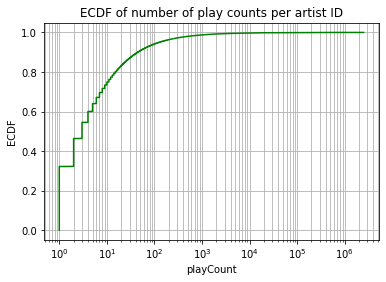

Sum = 371638969
Mean = 227.85566464830768
Max = 2502130
Min = 1
Percentile 25% = 1.0
Percentile 50% = 3.0
Percenrile 75% = 11.0
Percentile 90% = 45.0
Percentile 95% = 126.0
The percentage of artists how are listened once P(YArt=1) = 32.185%
The percentage of artists how are listened less than 1000 P(YArt<=1000) = 98.744%
Top listened artits : 
 [1425942 1542806 1930592 2259185 2502130]
Top listened artists and their percentage = 2.599%


In [ ]:
pdfArt = pd.DataFrame(data=artistPlayCount)
YArt = np.sort(pdfArt[1])
YArtVals = np.arange(len(YArt)) / float(len(YArt))

plt.semilogx(YArt, YArtVals, color='green')
plt.xlabel('playCount')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls='-')
plt.title('ECDF of number of play counts per artist ID')
plt.show()

print('Sum = {}'.format(YArt.sum()))
print('Mean = {}'.format(YArt.mean()))
print('Max = {}'.format(YArt.max()))
print('Min = {}'.format(YArt.min()))

print('Percentile 25% = {}'.format(np.percentile(YArt, 25)))
print('Percentile 50% = {}'.format(np.percentile(YArt, 50)))
print('Percenrile 75% = {}'.format(np.percentile(YArt, 75)))
print('Percentile 90% = {}'.format(np.percentile(YArt, 90)))
print('Percentile 95% = {}'.format(np.percentile(YArt, 95)))

print('The percentage of artists how are listened once P(YArt=1) = {0:.3f}%'.format(100*len(YArt[YArt==1])/len(YArt)))
print('The percentage of artists how are listened less than 1000 P(YArt<=1000) = {0:.3f}%'.format(100*len(YArt[YArt<=1000])/len(YArt)))
print('Top listened artits : \n', YArt[len(YArt)-5:])
print('Top listened artists and their percentage = {0:.3f}%'.format(100*YArt[len(YArt)-5:].sum() / YArt.sum()))



In [ ]:
SortedArtist = sorted(artistPlayCount, key=lambda x : -x[-1])[:5]
artistID = [ e[0] for e in SortedArtist]

y_pos = range(len(SortedArtist))
playCount = [ e[1] for e in SortedArtist]

plt.barh(y_pos, playCount[::-1], color='red', align='center', alpha=0.5)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('ArtistID')
plt.title('Top 5 Artists')
plt.show()

In [ ]:
ArtistDataSchema = StructType([
    StructField("artistID", LongType(), True),
    StructField("name", StringType(), True)
])

ArtistDF = sqlContext.read.format('com.databricks.spark.csv').options(header='false', delimiter='\t', mode='DROPMALFORMED').load(directory_path + 'artist_data.txt', schema=ArtistDataSchema).cache()

In [ ]:
ArtistDF.count()

In [ ]:
ArtistDF.show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
|10186265|Jota Quest e Ivet...|
| 6828986|       Toto_XX (1977|
|10236364|         U.S Bombs -|
| 1135000|artist formaly kn...|
|10299728|Kassierer - Musik...|
|10299744|         Rahzel, RZA|
| 6864258|      Jon Richardson|
| 6878791|Young Fresh Fello...|
|10299751|          Ki-ya-Kiss|
| 6909716|Underminded - The...|
|10435121|             Kox-Box|
| 6918061|  alexisonfire [wo!]|
| 1135001|         dj salinger|
| 6940391|The B52's - Chann...|
|10475396|             44 Hoes|
+--------+--------------------+
only showing top 20 rows



In [ ]:
ArtistDF[locate('aerosmith', ArtistDF.name)>0].show(20, False)
#Some conflicts in names and IDs of artists

In [ ]:
aliasArtistDataSchema = StructType([
    StructField("misspelledID", LongType(), True),
    StructField("standardID", LongType(), True)
])

aliasArtistDF = sqlContext.read.format('com.databricks.spark.csv').options(header='false', delimiter='\t', mode='DROPMALFORMED').load(directory_path + 'artist_alias.txt', schema=aliasArtistDataSchema).cache()

In [ ]:
aliasArtist = aliasArtistDF.rdd.map(lambda row : (row.misspelledID, row.standardID)).collectAsMap()

In [ ]:
print("MisspelledIDs StandardIDs")
aliasArtist

MisspelledIDs StandardIDs


{1092764: 1000311,
 1095122: 1000557,
 6708070: 1007267,
 10088054: 1042317,
 1195917: 1042317,
 1112006: 1000557,
 1187350: 1294511,
 1116694: 1327092,
 6793225: 1042317,
 1079959: 1000557,
 6789612: 1000591,
 1262241: 1000591,
 6791455: 1000591,
 6694867: 1000591,
 10141141: 1113738,
 1295140: 1000591,
 1027859: 1252408,
 2127019: 1000591,
 2153974: 1000591,
 1232342: 1000591,
 6968887: 1252408,
 1159841: 6826174,
 1195492: 1327092,
 7026209: 1246742,
 2012022: 1001590,
 1274042: 1327092,
 1073626: 668,
 None: 1329310,
 2038625: 1001646,
 1026463: 1327652,
 2039670: 1001646,
 6798013: 1002414,
 1069294: 1009335,
 2056950: 1010728,
 1003908: 1011075,
 6607001: 1013391,
 2051033: 1014131,
 2136930: 1018491,
 2040025: 1029792,
 2123236: 1068687,
 1017615: 668,
 1037679: 1003105,
 2056553: 1103336,
 1182866: 1157715,
 2080828: 1334990,
 1235280: 1003468,
 1182267: 1003468,
 1029279: 1327810,
 2177612: 1338247,
 2023293: 1003468,
 1036318: 1003468,
 2116355: 1003468,
 1080440: 1003468,
 1

In [ ]:
from time import time

aliasArtist2 = sc.broadcast(aliasArtist)

def replaceMisspelledIDs(fields):
  standardID = aliasArtist2.value.get(fields[1], fields[1])
  return (fields[0], standardID, fields[2])

t0 = time()

updatedUserArtistDF = sqlContext.createDataFrame(userArtistDF.rdd.map(replaceMisspelledIDs, userArtistDataSchema))
updatedUserArtistDF.show()

tf = time()

print('The script takes {}s for execution'.format(tf-t0))

updatedUserArtistDF = updatedUserArtistDF.cache()

In [ ]:
updatedUserArtistDF = updatedUserArtistDF.withColumnRenamed('_1', 'userID').withColumnRenamed('_2', 'artistID').withColumnRenamed('_3', 'playcount')

In [ ]:
updatedUserArtistDF.show()

+-------+--------+---------+
| userID|artistID|playcount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



In [ ]:
updatedDistinctArtists = updatedUserArtistDF.select('artistID').distinct().count()
print(" total number of distinct artists : {}".format(updatedDistinctArtists))

 total number of distinct artists : 1568126


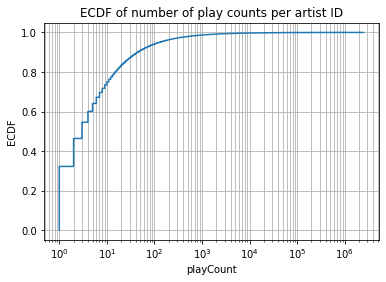

Sum = 371638969
Mean = 236.99560430730693
Max = 2502596
Min = 1
Percentile 25% = 1.0
Percentile 50% = 3.0
Percenrile 75% = 11.0
Percentile 90% = 45.0
Percentile 95% = 128.0
The percentage of artists how are listened once P(YArt=1) = 32.199%
The percentage of artists how are listened less than 1000 P(YArt<=1000) = 98.693%
Top listened artists : 
 [1426254 1543430 1931143 2259825 2502596]
Top 5 listened artists and their percentage = 2.600%


In [ ]:
updatedArtistPlaycount = updatedUserArtistDF.groupBy('artistID').sum('playcount').collect()
updatedPdfArt = pd.DataFrame(data=updatedArtistPlaycount)
updatedYArt = np.sort(updatedPdfArt[1])
updatedYArtVals = np.arange(len(updatedYArt)) / float(len(updatedYArt))

plt.semilogx(updatedYArt, updatedYArtVals)
plt.xlabel('playCount')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls='-')
plt.title('ECDF of number of play counts per artist ID')
plt.show()

print('Sum = {}'.format(updatedYArt.sum()))
print('Mean = {}'.format(updatedYArt.mean()))
print('Max = {}'.format(updatedYArt.max()))
print('Min = {}'.format(updatedYArt.min()))

print('Percentile 25% = {}'.format(np.percentile(updatedYArt, 25)))
print('Percentile 50% = {}'.format(np.percentile(updatedYArt, 50)))
print('Percenrile 75% = {}'.format(np.percentile(updatedYArt, 75)))
print('Percentile 90% = {}'.format(np.percentile(updatedYArt, 90)))
print('Percentile 95% = {}'.format(np.percentile(updatedYArt, 95)))

print('The percentage of artists how are listened once P(YArt=1) = {0:.3f}%'.format(100*len(updatedYArt[updatedYArt==1])/len(updatedYArt)))
print('The percentage of artists how are listened less than 1000 P(YArt<=1000) = {0:.3f}%'.format(100*len(updatedYArt[updatedYArt<=1000])/len(updatedYArt)))
print('Top listened artists : \n', updatedYArt[len(updatedYArt)-5:])
print('Top 5 listened artists and their percentage = {0:.3f}%'.format(100*updatedYArt[len(updatedYArt)-5:].sum() / updatedYArt.sum()))



In [ ]:
top10Artists = updatedUserArtistDF.groupBy('artistID').sum('playcount').orderBy('sum(playcount)', ascending=0).take(10)

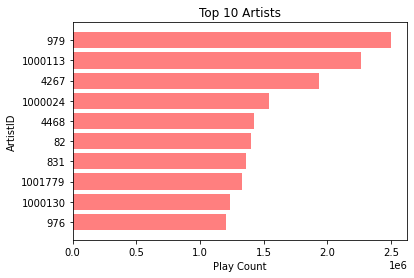

In [ ]:
pdfArt2 = pd.DataFrame(data=top10Artists)

y_pos2 = range(len(top10Artists))
playCount2 = pdfArt2[1]
artistID2 = pdfArt2[0]

plt.barh(y_pos2, playCount2[::-1], color='red', align='center', alpha=0.5)
plt.yticks(y_pos2, artistID2[::-1])
plt.xlabel('Play Count')
plt.ylabel('ArtistID')
plt.title('Top 10 Artists')
plt.show()

In [ ]:
top10Users = updatedUserArtistDF.groupBy('userID').sum('playcount').orderBy('sum(playcount)', ascending=0).take(10)

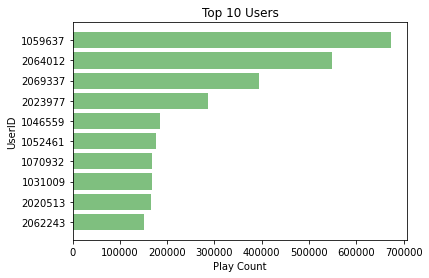

In [ ]:
pdfUsr2 = pd.DataFrame(data=top10Users)

y_pos3 = range(len(top10Users))
playCount3 = pdfUsr2[1]
userID3 = pdfUsr2[0]

plt.barh(y_pos3, playCount3[::-1], color='green', align='center', alpha=0.5)
plt.yticks(y_pos3, userID3[::-1])
plt.xlabel('Play Count')
plt.ylabel('UserID')
plt.title('Top 10 Users')
plt.show()

In [ ]:
top10UsersC = updatedUserArtistDF.dropDuplicates(['userID', 'artistID']).groupBy('userID').count().orderBy('count', ascending=0).take(10)

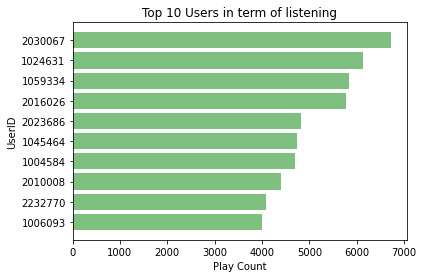

In [ ]:
pdfUsr3 = pd.DataFrame(data=top10UsersC)

y_pos4 = range(len(top10UsersC))
playCount4 = pdfUsr3[1]
userID4 = pdfUsr3[0]

plt.barh(y_pos4, playCount4[::-1], color='green', align='center', alpha=0.5)
plt.yticks(y_pos4, userID4[::-1])
plt.xlabel('Play Count')
plt.ylabel('UserID')
plt.title('Top 10 Users in term of listening')
plt.show()

# Statistic Model




In [8]:
rawArtistAlias = sc.textFile(directory_path + "artist_alias.txt")

def extract(s): 
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), int(line[1]))
        except ValueError:
            return (-1,-1)
    else:
        return (-1,-1)

In [9]:
artistAlias = rawArtistAlias.map(lambda x: extract(x)).filter(lambda x: x!= (-1, -1)).collectAsMap()

In [10]:
artistAlias2 = sc.broadcast(artistAlias)

In [11]:
rawUserArtist = sc.textFile(directory_path + 'user_artist_data.txt')

def correctMisspelled(line):
  [userID, artistID, pCount] = line.split(' ')
  standardArtistID = artistAlias2.value.get(artistID, artistID)
  return (userID, artistID, pCount)

In [12]:
userArtist = rawUserArtist.map(correctMisspelled)

In [13]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [14]:
dataSet = userArtist.map(lambda r: Rating(float(r[0]), float(r[1]), int(r[2]))).repartition(30).cache()

In [15]:
trainData, testData = dataSet.randomSplit([.8, .2], 1)
trainData.cache()
testData.cache()

PythonRDD[11] at RDD at PythonRDD.scala:53

In [16]:
rank, iterations, lambda_, alpha = 10, 5, 0.01, 40

In [17]:
t0 = time()
model = ALS.trainImplicit(trainData, rank, iterations, lambda_, alpha)
t1 = time()

print('training finished after {}s', format(t1-t0))

training finished after {}s 402.24497270584106


In [18]:
model.save(sc, 'capstoneProjectArtistsRecommendation.spark')
print('Model is saved.')

Model is saved.


In [ ]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'capstoneProjectArtistsRecommendation.spark')
t1 = time()
print('Model loaded after {}s.'.format(t1-t0))

Model loaded after 5.237917184829712s.


In [ ]:
trainData.take(5)

[Rating(user=1000002, product=1003495, rating=3.0),
 Rating(user=1000002, product=1003501, rating=2.0),
 Rating(user=1000002, product=1003511, rating=1.0),
 Rating(user=1000002, product=1003514, rating=5.0),
 Rating(user=1000002, product=1003515, rating=2.0)]

In [19]:
allItemsIDs = np.array(dataSet.map(lambda x:  x[1]).distinct().collect())

In [20]:
allItemsIDs2 = sc.broadcast(allItemsIDs)

In [21]:
from random import randint

def extractNegative(userIDsAndPosItemsIDs):

  def extractEnoughNegative(line):
    userID = line[0]
    posItemIDSet = set(line[1])
    negative = []
    allItemsIDs = allItemsIDs2.value
    i = 0
    while( i< len(allItemsIDs) and len(negative)<len(posItemIDSet) ):
      itemID = allItemsIDs[randint(0, len(allItemsIDs)-1)]
      if itemID not in posItemIDSet:
        negative.append(itemID)
      i += 1
    return map(lambda itemID: (userID, itemID), negative)

  return map(extractEnoughNegative, userIDsAndPosItemsIDs)

In [22]:
def ratioOfCorrectRanks(positiveRatings, negativeRatings):

    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
   
    correct = 0 
    total = 0 
    
    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    negativeRatings.sort()
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    return float(correct) / total

In [23]:
def computeAUC(positiveData, allItemIDs2, predictFunction):
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(extractNegative).flatMap(lambda x: x)
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (positivePredictions.join(negativePredictions).values().map(lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])).mean())

In [24]:
t0 = time()
auc = computeAUC( testData, allItemsIDs2, model.predictAll)
t1 = time()
print("AUC=",auc)
print("Predictions finished after {}" .format(t1-t0))

AUC= 0.9603278483259308
Predictions finished after 293.67347383499146
